In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re

In [7]:
# get input paths
test_set = "miplib_5000_gurobi"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False

## Check run failures

In [8]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "farkas": [],
    "prlp is primal infeasible": [],  # put outstanding bugs below here
    "must have primalbound > root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "warning": []
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols = {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                count_instances += len([f for f in os.listdir(series_fldr) if
                                        f.endswith(".mps")])
                names[stem] = instance

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    for code in err:
                        if code in text:
                            err[code].append(stem)
                            break
                    else:
                        other.append(stem)

Read MPS format model from file instances/miplib_5000_gurobi/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/10teams.mps
Reading time = 0.01 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/gmu-35-40.mps
Reading time = 0.00 seconds
gmu-35-40: 424 rows, 1205 columns, 4843 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-3610051-istr

In [9]:
# check which series didn't run
print(no_go)

[]


In [10]:
count_series

12720

In [11]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [12]:
# out of time - rerun with more time if a lot of these
print(err["walltime"])
len(err["walltime"]) / count_series

['timtab1CUTS_objective_1_64_New', 'timtab1CUTS_objective_1_64_Old', 'timtab1CUTS_matrix_-1_64_Old', 'timtab1CUTS_objective_-1_64_New', 'aflow40b_objective_-1_16_New', 'graphdraw-domain_matrix_-1_16_New', 'f2gap401600_objective_-1_16_New', 'pigeon-10_objective_1_16_None', 'csched008_matrix_1_64_New', 'csched008_matrix_-1_64_None', 'a1c1s1_objective_1_64_New', 'mtest4ma_objective_1_64_New', 'neos-2328163-agri_objective_1_4_None', 'neos-2328163-agri_objective_1_4_New', 'neos-2328163-agri_objective_1_4_Farkas', 'neos-2328163-agri_objective_1_16_None', 'neos-2328163-agri_objective_1_64_None', 'ns1208400_rhs_1_64_New', 'ns1208400_matrix_1_64_New', 'ns1208400_matrix_1_64_Old', 'ns1208400_bound_1_16_New', 'ns1208400_bound_1_16_Farkas', 'ns1208400_bound_1_64_New', 'ns1208400_bound_1_64_Old', 'ns1208400_bound_1_64_Farkas', 'bppc8-09_matrix_1_4_New', 'bppc8-09_matrix_1_4_Old', 'bppc8-09_matrix_1_4_Farkas', 'bppc8-09_matrix_1_16_New', 'bppc8-09_matrix_1_16_Old', 'bppc8-09_matrix_1_16_Farkas', 'bp

0.026415094339622643

In [13]:
# out of memory - rerun with more memory if a lot of these
print(err["bad_alloc"])
len(err["bad_alloc"]) / count_series

['neos-3610051-istra_rhs_-1_64_Farkas', 'neos-585192_matrix_-1_16_Old', 'neos-585192_matrix_-1_16_Farkas', 'neos-585192_matrix_-1_64_Old', 'neos-585192_matrix_-1_64_Farkas', 'neos-503737_objective_1_64_New', 'neos-503737_objective_1_64_Old', 'neos-503737_objective_1_64_Farkas', 'neos-503737_matrix_1_64_New', 'neos-503737_matrix_1_64_Old', 'neos-503737_matrix_1_64_Farkas', 'neos-503737_matrix_-1_64_New', 'neos-503737_matrix_-1_64_Old', 'neos-503737_matrix_-1_64_Farkas', 'neos-503737_objective_-1_64_New', 'neos-503737_objective_-1_64_Old', 'neos-503737_objective_-1_64_Farkas', 'neos-503737_bound_1_64_New', 'neos-503737_bound_1_64_Old', 'neos-503737_bound_1_64_Farkas', 'neos-574665_objective_1_64_Old', 'neos-574665_objective_1_64_Farkas', 'neos-574665_matrix_-1_64_Old', 'neos-574665_matrix_-1_64_Farkas', 'neos-574665_objective_-1_64_Old', 'neos-574665_objective_-1_64_Farkas', 'gesa2-o_objective_1_64_Old', 'gesa2-o_objective_1_64_Farkas', 'csched007_matrix_-1_16_Old', 'csched007_matrix_-1_

0.02610062893081761

In [14]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [15]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [16]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

['f2gap801600_bound_1_4_New', 'f2gap801600_bound_1_4_Old', 'f2gap801600_bound_1_4_Farkas', 'neos-585192_bound_1_16_New', 'neos-585192_bound_1_16_Old', 'neos-585192_bound_1_16_Farkas', 'neos-585192_bound_1_64_New', 'neos-585192_bound_1_64_Old', 'neos-585192_bound_1_64_Farkas', 'csched007_bound_1_4_New', 'csched007_bound_1_4_Old', 'csched007_bound_1_4_Farkas', 'csched007_bound_1_16_New', 'csched007_bound_1_16_Old', 'csched007_bound_1_16_Farkas', 'aflow40b_bound_1_4_New', 'aflow40b_bound_1_4_Old', 'aflow40b_bound_1_4_Farkas', 'aflow40b_bound_1_16_New', 'aflow40b_bound_1_16_Old', 'aflow40b_bound_1_16_Farkas', 'f2gap401600_bound_1_4_New', 'f2gap401600_bound_1_4_Old', 'f2gap401600_bound_1_4_Farkas', 'f2gap401600_bound_1_16_New', 'f2gap401600_bound_1_16_Old', 'f2gap401600_bound_1_16_Farkas', 'mcsched_bound_1_4_New', 'mcsched_bound_1_4_Old', 'mcsched_bound_1_4_Farkas', 'mcsched_bound_1_16_New', 'mcsched_bound_1_16_Old', 'mcsched_bound_1_16_Farkas', 'qnet1_o_bound_1_4_New', 'qnet1_o_bound_1_4_O

0.018789308176100628

In [17]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

['f2gap801600_bound_1_4_None', 'f2gap801600_bound_1_16_None', 'f2gap801600_bound_1_64_None', '10teams_bound_1_4_None', '10teams_bound_1_16_None', '10teams_bound_1_64_None', 'neos-585192_bound_1_4_None', 'neos-585192_bound_1_16_None', 'neos-585192_bound_1_64_None', 'neos-555343_bound_1_4_None', 'neos-555343_bound_1_16_None', 'neos-555343_bound_1_64_None', 'neos-503737_bound_1_4_None', 'neos-503737_bound_1_16_None', 'neos-503737_bound_1_64_None', 'csched007_bound_1_4_None', 'csched007_bound_1_16_None', 'csched007_bound_1_64_None', 'aflow40b_bound_1_4_None', 'aflow40b_bound_1_16_None', 'aflow40b_bound_1_64_None', 'f2gap401600_bound_1_4_None', 'f2gap401600_bound_1_16_None', 'f2gap401600_bound_1_64_None', 'p2756_bound_1_4_None', 'p2756_bound_1_16_None', 'p2756_bound_1_64_None', 'mcsched_bound_1_4_None', 'mcsched_bound_1_16_None', 'mcsched_bound_1_64_None', 'qnet1_o_bound_1_4_None', 'qnet1_o_bound_1_16_None', 'qnet1_o_bound_1_64_None', 'csched008_bound_1_4_None', 'csched008_bound_1_16_None',

0.016037735849056604

In [19]:
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_matrix_1_64_New', 'bienst2_matrix_1_64_Old', 'bienst2_matrix_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_objective_1_64_Old', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_objective_-1_64_Farkas', 'f2gap801600_bound_1_64_New', 'f2gap801600_bound_1_64_Old', 'f2gap801600_bound_1_64_Farkas', '10teams_objective_1_4_New', '10teams_objective_1_4_Old', '10teams_objective_1_4_Farkas', '10teams_objective_1_16_New', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_objective_1_64_New', '10teams_objective_1_64_Old', '10teams_objective_1_64_Farkas', '10teams_matrix_1_4_New', '10teams_matrix_1_4_Old', '10teams_matrix_1_4_Farkas', '10teams_matrix_1_16_New', '10teams_matrix_1_16_Old', '10teams_matrix_1_16_Farkas', '10tea

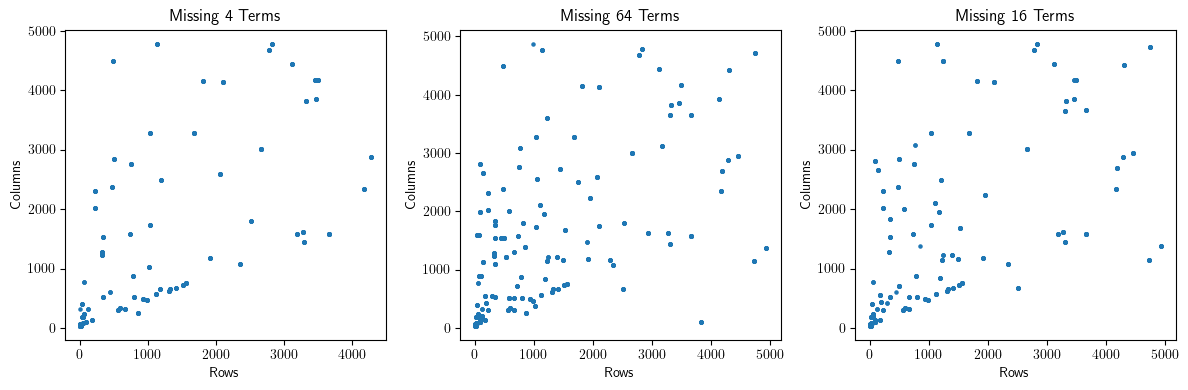

In [122]:
# use latex fonts
plt.rc('text', usetex=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot for list_1
axes[0].scatter([rows[names[n]] for n in missing_4_term],
                [cols[names[n]] for n in missing_4_term], s=5)
axes[0].set_title('Missing 4 Terms')
axes[0].set_xlabel('Rows')
axes[0].set_ylabel('Columns')

# Plot for list_2
axes[1].scatter([rows[names[n]] for n in missing_64_term],
                [cols[names[n]] for n in missing_64_term], s=5)
axes[1].set_title('Missing 64 Terms')
axes[1].set_xlabel('Rows')
axes[1].set_ylabel('Columns')

# Plot for list_3
axes[2].scatter([rows[names[n]] for n in missing_16_term],
                [cols[names[n]] for n in missing_16_term], s=5)
axes[2].set_title('Missing 16 Terms')
axes[2].set_xlabel('Rows')
axes[2].set_ylabel('Columns')

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
# this may be a bug in my code - track down if a lot
print(err["farkas"])
len(err["farkas"]) / count_series

['bienst2_rhs_1_4_New', 'bienst2_matrix_1_4_New', 'bienst2_matrix_-1_16_New', 'f2gap801600_objective_1_16_New', 'f2gap801600_objective_1_16_Old', 'f2gap801600_objective_1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Old', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'gmu-35-40_objective_1_4_New', 'gmu-35-40_objective_1_16_New', 'gmu-35-40_objective_1_64_New', 'gmu-35-40_objective_1_64_Old', 'gmu-35-40_objective_1_64_Farkas', 'gmu-35-40_rhs_-1_64_New', 'gmu-35-40_rhs_-1_64_Old', 'gmu-35-40_rhs_-1_64_Farkas', 'gmu-35-40_matrix_-1_64_New', 'gmu-35-40_matrix_-1_64_Old', 'gmu-35-40_matrix_-1_64_Farkas', 'gmu-35-40_objective_-1_4_New', 'gmu-35-40_objective_-1_16_New', 'gmu-35-40_objective_-1_64_New', 'gmu-35-40_objective_-1_64_Old', 'gmu-35-40_objective_-1_64_Farkas', 'neos-585192_matrix_-1_4_New', 'neos-585192_matrix_-1_4_Old', 'neos-585192_matrix_-1_4_Farkas', 'neos-585192_b

0.030267295597484277

In [22]:
# this shouldn't be an issue - effected runs just get skipped
print(err["prlp is primal infeasible"])
len(err["prlp is primal infeasible"]) / count_series

['gmu-35-40_objective_1_4_Old', 'gmu-35-40_objective_1_16_Old', 'gmu-35-40_rhs_-1_4_Old', 'gmu-35-40_rhs_-1_16_Old', 'gmu-35-40_matrix_-1_4_Old', 'gmu-35-40_matrix_-1_16_Old', 'gmu-35-40_objective_-1_4_Old', 'gmu-35-40_objective_-1_16_Old', 'neos-3610051-istra_matrix_-1_4_Old', 'neos-3610051-istra_matrix_-1_16_Old', 'neos-574665_objective_1_4_Old', 'neos-574665_objective_-1_4_Old', 'gesa2-o_matrix_-1_4_Old', 'gesa2-o_matrix_-1_16_Old', 'gesa2-o_matrix_-1_64_Old', 'csched007_matrix_-1_4_Old', 'aflow40b_matrix_1_4_Old', 'aflow40b_matrix_-1_4_Old', 'aflow40b_objective_-1_4_Old', 'graphdraw-domain_rhs_1_16_Old', 'graphdraw-domain_rhs_-1_16_New', 'graphdraw-domain_rhs_-1_16_Old', 'graphdraw-domain_matrix_-1_16_Old', 'blend2_matrix_1_4_Old', 'blend2_matrix_1_16_Old', 'blend2_matrix_1_64_Old', 'blend2_matrix_-1_4_Old', 'modglob_matrix_1_4_Old', 'modglob_matrix_1_16_Old', 'modglob_matrix_1_64_Old', 'sp150x300d_matrix_1_4_Old', 'sp150x300d_matrix_1_16_Old', 'sp150x300d_matrix_1_64_Old', 'ran13x

0.024528301886792454

In [23]:
print(err["warning"])
len(err["warning"]) / count_series

['bienst2_rhs_1_16_New', 'bienst2_rhs_1_16_Old', 'bienst2_matrix_1_16_New', 'bienst2_matrix_-1_16_Old', 'neos-3610173-itata_matrix_-1_64_Old', 'neos-3610051-istra_matrix_-1_64_Old', 'timtab1CUTS_matrix_-1_64_New', 'neos-574665_objective_1_16_Old', 'neos-574665_matrix_-1_16_Old', 'modglob_rhs_1_16_New', 'modglob_rhs_1_64_New', 'modglob_matrix_1_16_New', 'modglob_matrix_1_64_New', 'mcsched_objective_1_16_New', 'mcsched_objective_1_16_Old', 'mcsched_matrix_1_16_New', 'mcsched_matrix_1_16_Old', 'mcsched_objective_-1_16_Old', 'neos-1396125_rhs_1_4_New', 'neos-1396125_rhs_1_4_Old', 'neos-1396125_objective_1_4_Old', 'neos-1396125_matrix_-1_4_New', 'neos-1396125_matrix_-1_4_Old', 'neos-1396125_objective_-1_4_Old', 'dfn-gwin-UUM_matrix_1_64_Old', 'dfn-gwin-UUM_matrix_-1_64_Old', 'n4-3_objective_1_16_New', 'n4-3_objective_1_16_Old', 'n4-3_matrix_-1_16_New', 'n4-3_matrix_-1_16_Old', 'n4-3_objective_-1_16_Old', 'mtest4ma_matrix_1_4_New', 'mtest4ma_matrix_1_16_New', 'mtest4ma_matrix_1_64_New', 'neo

0.019968553459119496

In [24]:
# issue was not optimizing solver before checking LP relaxation objective vs primal bound
print(err["must have primalbound > root lp objective"])
len(err["must have primalbound > root lp objective"]) / count_series

['neos-1171737_matrix_1_4_None', 'neos-1171737_matrix_1_16_None', 'neos-1171737_matrix_1_64_None', 'neos-1171737_matrix_-1_4_None', 'neos-1171737_matrix_-1_16_None', 'neos-1171737_matrix_-1_64_None', 'neos-1171737_bound_1_4_None', 'neos-1171737_bound_1_16_None', 'neos-1171737_bound_1_64_None', 'neos-3421095-cinca_rhs_-1_4_None', 'neos-3421095-cinca_rhs_-1_16_None', 'neos-3421095-cinca_rhs_-1_64_None', 'neos-3421095-cinca_matrix_-1_4_None', 'neos-3421095-cinca_matrix_-1_16_None', 'neos-3421095-cinca_matrix_-1_64_None', 'neos-693347_matrix_1_4_None', 'neos-693347_matrix_1_16_None', 'neos-693347_matrix_1_64_None', 'neos-1425699_rhs_-1_4_None', 'neos-1425699_rhs_-1_16_None', 'neos-1425699_rhs_-1_64_None', 'neos-1425699_matrix_-1_4_None', 'neos-1425699_matrix_-1_16_None', 'neos-1425699_matrix_-1_64_None', 'cod105_bound_1_4_None', 'cod105_bound_1_16_None', 'cod105_bound_1_64_None', 'neos-1601936_rhs_1_4_None', 'neos-1601936_rhs_1_16_None', 'neos-1601936_rhs_1_64_None', 'neos-5192052-neckar_m

0.02130503144654088

In [25]:
# LP relxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [26]:
# not enough tolerance added to bound (or we hit time limit)
# todo handle this gracefully
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

[]


0.0

In [27]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

['neos-3610173-itata_rhs_-1_16_New', 'neos-3610173-itata_rhs_-1_64_New', 'neos-3610173-itata_matrix_-1_16_New', 'neos-3610173-itata_matrix_-1_64_New', 'neos-3610051-istra_rhs_-1_16_New', 'neos-3610051-istra_rhs_-1_64_New', 'neos-3610051-istra_matrix_-1_16_New', 'neos-3610051-istra_matrix_-1_64_New', 'neos-585192_matrix_-1_16_New', 'neos-585192_matrix_-1_64_New', 'neos-3046601-motu_matrix_1_64_New', 'neos-574665_rhs_-1_16_New', 'neos-574665_rhs_-1_64_New', 'neos-574665_matrix_-1_16_New', 'neos-574665_matrix_-1_64_New', 'csched007_matrix_-1_16_New', 'graphdraw-domain_matrix_1_16_New', 'blend2_matrix_1_16_New', 'blend2_matrix_1_64_New', 'blend2_matrix_-1_16_New', 'blend2_matrix_-1_64_New', 'neos-3611447-jijia_rhs_1_16_New', 'neos-3611447-jijia_rhs_1_64_New', 'dfn-gwin-UUM_matrix_1_64_New', 'dfn-gwin-UUM_matrix_-1_64_New', 'breastcancer-regularized_matrix_-1_16_New', 'timtab1_matrix_1_64_New', 'gen-ip036_rhs_1_16_New', 'gen-ip036_rhs_1_64_New', 'gen-ip036_matrix_1_16_New', 'gen-ip036_matri

0.005581761006289308

In [28]:
# this and next issue I think are because we run out of time creating tree leading to errors
# todo: handle gracefully 
print(err["nonbasic reduced cost should be"])
len(err["nonbasic reduced cost should be"]) / count_series

['gmu-35-40_objective_1_4_Farkas', 'gmu-35-40_rhs_-1_4_New', 'gmu-35-40_rhs_-1_4_Farkas', 'gmu-35-40_matrix_-1_4_New', 'gmu-35-40_matrix_-1_4_Farkas', 'gmu-35-40_objective_-1_4_Farkas', 'timtab1CUTS_objective_-1_64_Old', 'sp150x300d_matrix_1_4_New', 'sp150x300d_matrix_1_4_Farkas', 'sp150x300d_matrix_1_16_New', 'sp150x300d_matrix_1_16_Farkas', 'sp150x300d_matrix_1_64_New', 'sp150x300d_matrix_1_64_Farkas', 'sp150x300d_rhs_-1_16_New', 'sp150x300d_rhs_-1_16_Old', 'sp150x300d_rhs_-1_64_New', 'sp150x300d_rhs_-1_64_Old', 'sp150x300d_rhs_-1_64_Farkas', 'sp150x300d_matrix_-1_4_New', 'sp150x300d_matrix_-1_4_Old', 'sp150x300d_matrix_-1_4_Farkas', 'sp150x300d_matrix_-1_16_New', 'sp150x300d_matrix_-1_16_Old', 'sp150x300d_matrix_-1_16_Farkas', 'sp150x300d_matrix_-1_64_Old', 'sp150x300d_matrix_-1_64_Farkas', 'mas74_matrix_1_4_New', 'mas74_matrix_-1_4_New', 'bppc8-09_matrix_-1_64_New', 'breastcancer-regularized_objective_1_16_Old', 'gsvm2rl3_matrix_1_4_New', 'gsvm2rl3_matrix_1_16_Old', 'gsvm2rl3_matri

0.0037735849056603774

In [29]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

['neos-850681_rhs_1_16_New', 'neos-850681_rhs_1_16_Old', 'neos-850681_rhs_1_16_Farkas', 'neos-850681_objective_1_16_New', 'neos-850681_objective_1_16_Old', 'neos-850681_objective_1_16_Farkas', 'neos-850681_matrix_1_16_New', 'neos-850681_matrix_1_16_Old', 'neos-850681_matrix_1_16_Farkas', 'neos-850681_matrix_-1_16_New', 'neos-850681_matrix_-1_16_Old', 'neos-850681_matrix_-1_16_Farkas', 'neos-850681_objective_-1_16_New', 'neos-850681_objective_-1_16_Old', 'neos-850681_objective_-1_16_Farkas', 'neos-850681_bound_1_16_New', 'neos-850681_bound_1_16_Old', 'neos-850681_bound_1_16_Farkas']


0.0014150943396226414

In [30]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

['sp98ir_rhs_-1_64_Farkas', 'sp98ir_objective_-1_64_Farkas', 'neos-916792_matrix_-1_16_None', '50v-10_objective_-1_16_Farkas']


0.00031446540880503143

In [31]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [32]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-574665_rhs_-1_4_New', 'neos-574665_rhs_-1_4_Old', 'neos-574665_rhs_-1_4_Farkas', 'neos-574665_rhs_-1_16_Old', 'neos-574665_rhs_-1_16_Farkas', 'neos-574665_rhs_-1_64_Old', 'neos-574665_rhs_-1_64_Farkas', 'neos-574665_objective_-1_16_Farkas', 'gen-ip054_objective_-1_4_None', 'gen-ip054_objective_-1_16_None', 'gen-ip054_objective_-1_64_None', 'gen-ip054_objective_-1_64_Farkas', 'cov1075_rhs_1_64_Farkas', 'rococoC10-001000_objective_1_16_New', 'ns1830653_rhs_1_16_Farkas', 'ns1830653_matrix_1_16_Farkas', 'ns1830653_matrix_-1_16_Farkas', 'mik-250-1-100-1_rhs_-1_4_Farkas', 'neos-480878_objective_1_4_New', 'neos-480878_objective_1_16_New', 'neos-480878_objective_1_64_New', 'eil33-2_objective_1_4_New', 'neos16_rhs_1_4_New', 'neos16_rhs_1_4_Old', 'neos16_rhs_1_16_New', 'neos16_rhs_1_16_Old', 'neos16_rhs_1_16_Farkas', 'neos16_matrix_1_4_New', 'neos16_matrix_1_4_Farkas', 'neos16_matrix_1_16_Farkas', 'neos16_rhs_-1_16_Farkas', 'neos-911970_rhs_-1_4_None', 'neos-911970_rhs_-1_4_New', 'neos-91

0.004481132075471698

In [33]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["walltime"])) / count_series

0.052515723270440254

## Read in data

In [49]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = match.group(1)
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])

In [50]:
# get proportion of instances run
for generator, df in df_map.items():
    print(f"{generator}: {4 * len(df) / count_instances}")

None: 0.9114777712302756
Farkas: 0.494598310744451
New: 0.4439206442742094
Old: 0.4359326916781248


In [51]:
gen = "Farkas" # make sure masks 3 and 9 are fixed rest should be fine
masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"],
        2: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"],
        3: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"],
        4: df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"],
        5: df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"],
        6: df_map[gen]["primalBound"] > 1e20,
        7: 0 > df_map[gen]["vpcGenerationTime"],
        8: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"],
        9: df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"],
        10: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"],
        11: df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"],
        12: df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20
    }

df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,iterations,maxTime,actualTerms,numCuts,cutLimit,mipSolver,providePrimalBound,instance,perturbation,degree


In [52]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"]) | \
        (df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"]) | \
        (df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"]) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20)
    df_map[gen] = df_map[gen][~mask]

In [53]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,bestSolutionTime Farkas,terminationTime Farkas,nodes Farkas,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas
0,0,None,64,2.910894e+02,2.910894e+02,2.910894e+02,3.036667e+02,3.070000e+02,3.070000e+02,0.000039,...,7.833717,7.836244,24,370,5.00,65,1,6,GUROBI,1
1,1,None,64,2.759567e+02,2.759567e+02,2.759567e+02,2.916650e+02,3.050000e+02,3.050000e+02,0.000005,...,2.568078,2.568175,2080,16786,5.00,65,1,0,GUROBI,1
2,0,None,16,6.519542e+06,6.519542e+06,6.519542e+06,1.148617e+07,1.149067e+07,1.149067e+07,0.000006,...,25.061873,29.422018,580,52171,109.00,33,2,202,GUROBI,1
3,0,None,4,2.654737e+03,2.654737e+03,2.654737e+03,2.685080e+03,2.713000e+03,2.713000e+03,0.000003,...,649.049945,649.050282,1711,214888,923.46,4,182,182,GUROBI,1
4,1,None,4,2.577192e+03,2.577192e+03,2.577192e+03,2.627976e+03,2.665000e+03,2.665000e+03,0.000004,...,30.819243,34.337064,836,121323,923.46,4,182,0,GUROBI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4586,0,None,16,2.264037e+04,2.264037e+04,2.264037e+04,3.210276e+04,3.290671e+04,3.565831e+04,0.000002,...,209.783195,209.790862,584,9473,341.35,212,7,63,GUROBI,1
4587,0,None,16,1.200000e-02,1.200000e-02,1.200000e-02,9.048700e-02,3.365280e-01,3.365280e-01,0.000003,...,69.940950,69.941059,11272,297285,803.11,16,31,31,GUROBI,1
4588,1,None,16,1.190200e-02,1.190200e-02,1.190200e-02,5.255700e-02,2.948790e-01,2.948790e-01,0.000003,...,9.532844,42.685912,14545,429719,803.11,16,31,0,GUROBI,1
4589,2,None,16,1.094500e-02,1.094500e-02,1.094500e-02,5.015200e-02,2.832750e-01,2.832750e-01,0.000002,...,27.036226,28.398350,14971,274751,803.11,16,31,0,GUROBI,1


In [54]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.3005958226936424

In [55]:
def gap_closed(df, col):
    gap = (df[col] - df["lpBound None"]) / (df['primalBound None'] - df["lpBound None"])
    gap[(gap < 0) | (gap > 1)] = np.nan
    return gap

In [56]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = (df["Root Cuts (Farkas)"] - df["Root Cuts (None)"]) / df["Root Cuts (None)"] 
df = df.dropna()

In [57]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_40597/2524607786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc None"] = df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_40597/2524607786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_40597/2524607786.py:4: SettingWithCopyWarni

In [58]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [59]:
# get rid of instances that solved trivially quickly
mean_run = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) &
                              (optimality_gap(df_map["None"]) <= 1e-4)].groupby("instance")["terminationTime"].mean().to_dict()
toss = [instance for instance, time in mean_run.items() if time < 1]
df = df.loc[~df["instance"].isin(toss)]

In [60]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
2,0,None,16,6.519542e+06,6.519542e+06,6.519542e+06,1.148617e+07,1.149067e+07,1.149067e+07,0.000006,...,0.754958,0.742500,0.762313,27.805681,5.250303,5.178979,5.313947,-0.031041,0.943226,0.781125
3,0,None,4,2.654737e+03,2.654737e+03,2.654737e+03,2.685080e+03,2.713000e+03,2.713000e+03,0.000003,...,2.195074,2.189915,2.168681,6.103827,34.355182,34.361039,34.381177,-81.254324,-2.228302,-2.691790
4,1,None,4,2.577192e+03,2.577192e+03,2.577192e+03,2.627976e+03,2.665000e+03,2.665000e+03,0.000004,...,2.018160,2.019586,2.059620,19.800764,28.955958,28.852049,28.832683,-0.573718,0.156408,-0.527228
5,3,None,4,2.471642e+03,2.471642e+03,2.471642e+03,2.624556e+03,2.696000e+03,2.696000e+03,0.000004,...,3.813358,4.491156,4.773309,159.574500,149.488803,156.860748,156.848422,-0.013182,0.295190,-0.139385
8,0,None,16,3.016944e+03,3.016944e+03,3.016944e+03,3.370978e+03,3.711629e+03,3.712000e+03,0.000026,...,0.538283,0.515414,0.516316,1730.012085,1976.276216,1955.179280,1941.456162,-0.130844,0.032488,-0.081492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4586,0,None,16,2.264037e+04,2.264037e+04,2.264037e+04,3.210276e+04,3.290671e+04,3.565831e+04,0.000002,...,2.185032,2.140714,2.195021,23.692661,12.472768,12.679193,12.482944,-6.727239,0.086072,0.404439
4587,0,None,16,1.200000e-02,1.200000e-02,1.200000e-02,9.048700e-02,3.365280e-01,3.365280e-01,0.000003,...,0.188630,0.189733,0.197241,34.327023,37.591442,37.519894,38.909514,-1.030247,-0.046417,-0.071263
4588,1,None,16,1.190200e-02,1.190200e-02,1.190200e-02,5.255700e-02,2.948790e-01,2.948790e-01,0.000003,...,0.193025,0.194105,0.194426,31.961095,49.041344,12.442720,41.835455,-0.329778,-0.425701,-0.412420
4589,2,None,16,1.094500e-02,1.094500e-02,1.094500e-02,5.015200e-02,2.832750e-01,2.832750e-01,0.000002,...,0.197270,0.230694,0.138256,33.785165,29.597598,26.519177,27.461417,0.164389,-0.370218,-0.045277


In [70]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip 0th indexed runs and runs where VPC finds the optimal solution
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999) 

## Make bound table

In [62]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
4,aligninq,matrix,0.5,4,1,0.261460,0.098407,0.178522,0.088428,0.046450,0.578354,0.567358,0.567358,0.567358
5,aligninq,matrix,0.5,4,3,0.117104,0.015613,0.053829,0.009090,0.000375,0.681563,0.687696,0.697908,0.697908
9,ran14x18,objective,2.0,16,1,0.053458,0.027873,0.049970,0.021266,0.000000,0.654902,0.641775,0.652699,0.652699
10,ran14x18,objective,2.0,16,3,0.053967,0.010371,0.051768,0.009509,0.000000,0.535510,0.538979,0.559060,0.564650
11,ran14x18,objective,2.0,16,4,0.104832,0.024089,0.042781,0.024089,0.000000,0.674679,0.650999,0.674069,0.671168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,gen-ip054,matrix,2.0,64,1,0.113531,0.047588,0.109683,0.044914,0.000000,0.048122,0.109730,0.049114,0.048122
4584,gen-ip054,matrix,2.0,64,3,0.108932,0.041737,0.107588,0.039239,0.000000,0.064200,0.108453,0.064200,0.064200
4588,gsvm2rl3,matrix,2.0,16,1,0.142284,0.134711,0.137665,0.084116,0.022136,0.143669,0.313669,0.291868,0.230627
4589,gsvm2rl3,matrix,2.0,16,2,0.148269,0.084959,0.025153,0.049660,0.003485,0.143969,0.142797,0.148261,0.069500


In [63]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [64]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,instanceIndex
0,0.5,4,0.088397,0.031387,0.037951,0.023831,0.019285,0.625821,0.626454,0.627532,0.626755,103,708
1,0.5,16,0.132917,0.070998,0.061265,0.045870,0.033759,0.621655,0.627906,0.624182,0.623321,66,437
2,0.5,64,0.179087,0.113671,0.087772,0.072458,0.058987,0.688149,0.697088,0.692712,0.690936,46,278
3,2.0,4,0.105395,0.033512,0.035795,0.025024,0.016991,0.638842,0.640108,0.638715,0.639189,88,565
4,2.0,16,0.176029,0.064904,0.057998,0.040255,0.019141,0.643896,0.648224,0.645683,0.643938,67,421
5,2.0,64,0.245104,0.099145,0.087524,0.063553,0.033603,0.693474,0.701864,0.695449,0.694588,51,267


In [65]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.103458           0.029212    0.044317   
             objective              0.035150           0.032237    0.027034   
             rhs                    0.145030           0.033509    0.044437   
       16    matrix                 0.139350           0.071758    0.071092   
             objective              0.089708           0.078916    0.053297   
             rhs                    0.184771           0.059307    0.061080   
       64    matrix                 0.165114           0.115450    0.094439   
             objective              0.150128           0.137450    0.091898   
             rhs                    0.227678           0.083468    0.076172   
2.0    4     matrix                 0.071040           0.025602    0.040307   
             objective              0.049048           0.040004    0.034562   
             rhs                    0.242460           0.029426    0.033603   
       16    matrix                 0.147334           0.061368    0.076655   
             objective              0.099875           0.067931    0.051587   
             rhs                    0.359802           0.061792    0.054581   
       64    matrix                 0.196730           0.098476    0.094199   
             objective              0.171093           0.112323    0.097757   
             rhs                    0.408417           0.077057    0.064953   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.022608       0.015242          0.631119   
             objective       0.024265       0.022381          0.634080   
             rhs             0.025089       0.020944          0.605102   
       16    matrix          0.047338       0.027238          0.619325   
             objective       0.048222       0.041804          0.637799   
             rhs             0.040997       0.030110          0.602198   
       64    matrix          0.079746       0.054159          0.645956   
             objective       0.083986       0.080080          0.710731   
             rhs             0.051391       0.038600          0.703345   
2.0    4     matrix          0.019753       0.012390          0.622751   
             objective       0.028605       0.021238          0.660084   
             rhs             0.023664       0.013752          0.615818   
       16    matrix          0.044177       0.012193          0.678877   
             objective       0.037533       0.021226          0.610027   
             rhs             0.042392       0.021042          0.682840   
       64    matrix          0.071241       0.013545          0.744670   
             objective       0.071088       0.048443          0.654736   
             rhs             0.044844       0.023271          0.721320   

                           Root Cuts (New)  Root Cuts (Old)  \
degree terms perturbation                                     
0.5    4     matrix               0.630447         0.632835   
             objective            0.634481         0.635467   
             rhs                  0.608124         0.607296   
       16    matrix               0.623852         0.621214   
             objective            0.642028         0.639356   
             rhs                  0.613159         0.606774   
       64    matrix               0.657506         0.653981   
             objective            0.712722         0.712292   
             rhs                  0.717980         0.708036   
2.0    4     matrix               0.624873         0.621674   
             objective            0.660141         0.658975   
             rhs                  0.618454         0.618426   
       16    matrix               0.686402         0.683990   
             objecti

## Make Profiles

In [85]:
def make_plots(prof_df, metric, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 7200,
                "terminationTimeSansVpc": 7200,
                "terminationTime": 7200,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 10000,
                "iterations": 50000
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= 1e-4")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                 f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{"perturbing only " + perturbation if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                 fontsize=16)

    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [86]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
       (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4)  # only check the ones that solve to optimality
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,442.737611,450.663456,447.431156,397.296460,387.249225,414.340222,446.583133,397.296460,...,386.064563,413.119137,445.364658,396.144593,55.488386,36.323233,0.848023,-0.362938,98,589
1,0.5,16,580.377412,563.994882,545.218212,480.867243,541.652765,540.869865,542.613745,480.867243,...,540.968503,540.217428,541.978442,480.205841,38.724647,23.125017,2.604467,-0.351438,62,377
2,0.5,64,541.754037,491.127177,402.263252,414.727359,387.692269,400.921548,397.610076,414.727359,...,387.090483,400.302401,396.992345,414.119870,154.061768,90.205629,4.653176,-0.893532,44,247
3,2.0,4,311.735789,326.709832,291.042434,298.883061,259.183257,283.478492,290.269004,298.883061,...,258.190832,282.434999,289.231514,297.861660,52.552531,43.231340,0.773430,-0.257947,83,492
4,2.0,16,309.242090,330.084817,265.014774,297.922425,250.528173,287.894617,262.527179,297.922425,...,249.913607,287.294012,261.925070,297.290825,58.713917,42.190200,2.487595,-0.905669,62,369
5,2.0,64,386.948097,311.339726,274.281231,246.408930,266.195197,264.225684,270.271820,246.408930,...,265.757147,263.736034,269.777774,245.926833,120.752900,47.114042,4.009410,-2.442867,48,231


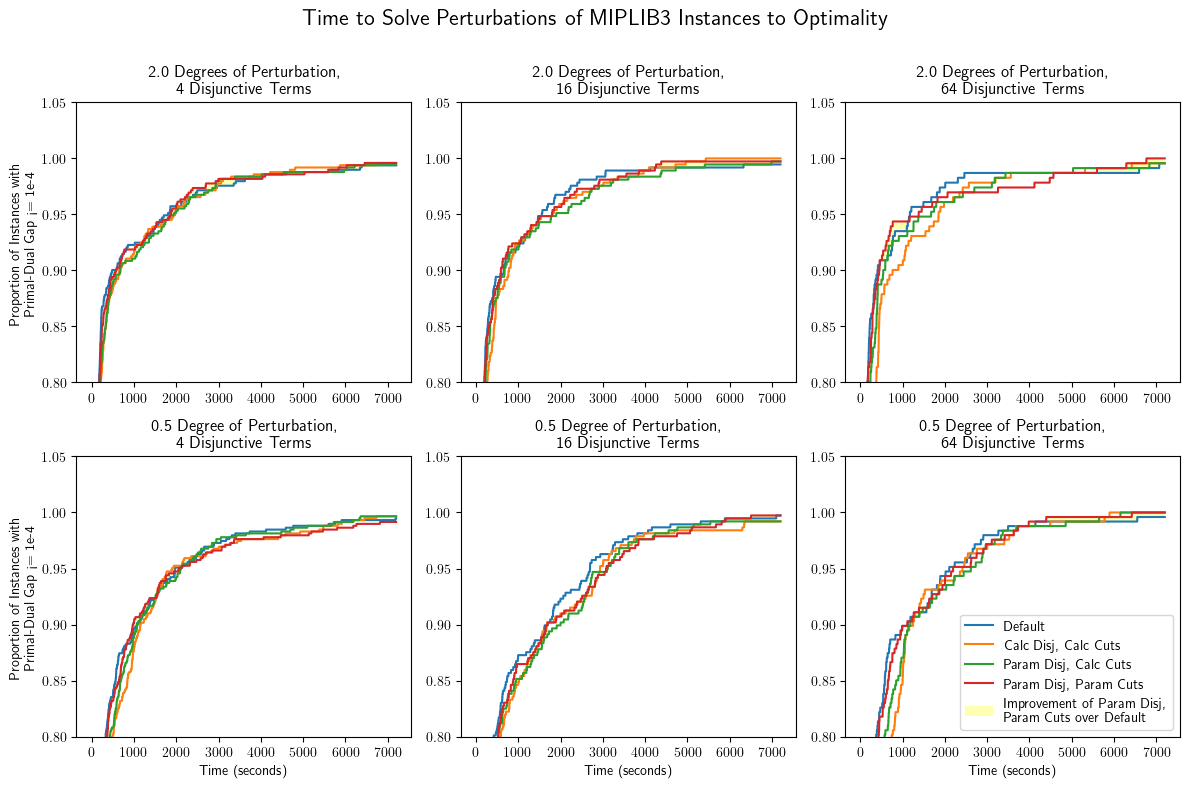

In [87]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [88]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,442.912127,409.161246,402.791895,453.572148,-0.000363,98,589
1,0.5,16,700.768085,829.742653,763.642048,802.812273,-0.000351,62,377
2,0.5,64,283.546154,341.838381,337.511154,341.362283,-0.000894,44,247
3,2.0,4,304.254677,294.077118,305.785388,283.317291,-0.000258,83,492
4,2.0,16,432.584789,455.557753,463.570583,415.623837,-0.000906,62,369
5,2.0,64,278.684506,274.938394,313.753762,280.817281,-0.002443,48,231


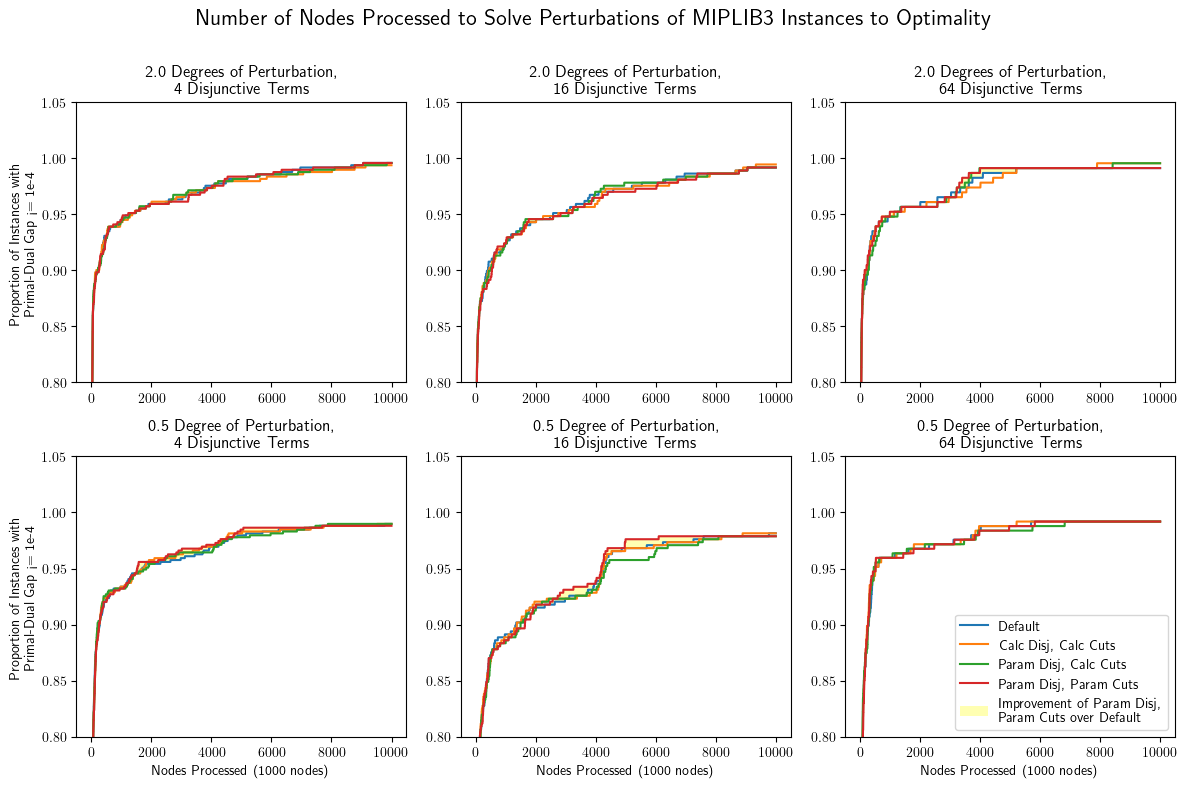

In [89]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [90]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,2787.753876,2679.563258,2844.632581,2816.451081,-0.000363,98,589
1,0.5,16,4107.836658,4529.866756,4263.956777,4391.002541,-0.000351,62,377
2,0.5,64,2563.081834,2755.254081,2728.807049,2725.977555,-0.000894,44,247
3,2.0,4,2207.068892,2230.455341,2286.917850,2208.167756,-0.000258,83,492
4,2.0,16,2383.992813,2515.085837,2541.553257,2309.412398,-0.000906,62,369
5,2.0,64,1809.085740,1875.079606,1787.768208,1786.971779,-0.002443,48,231


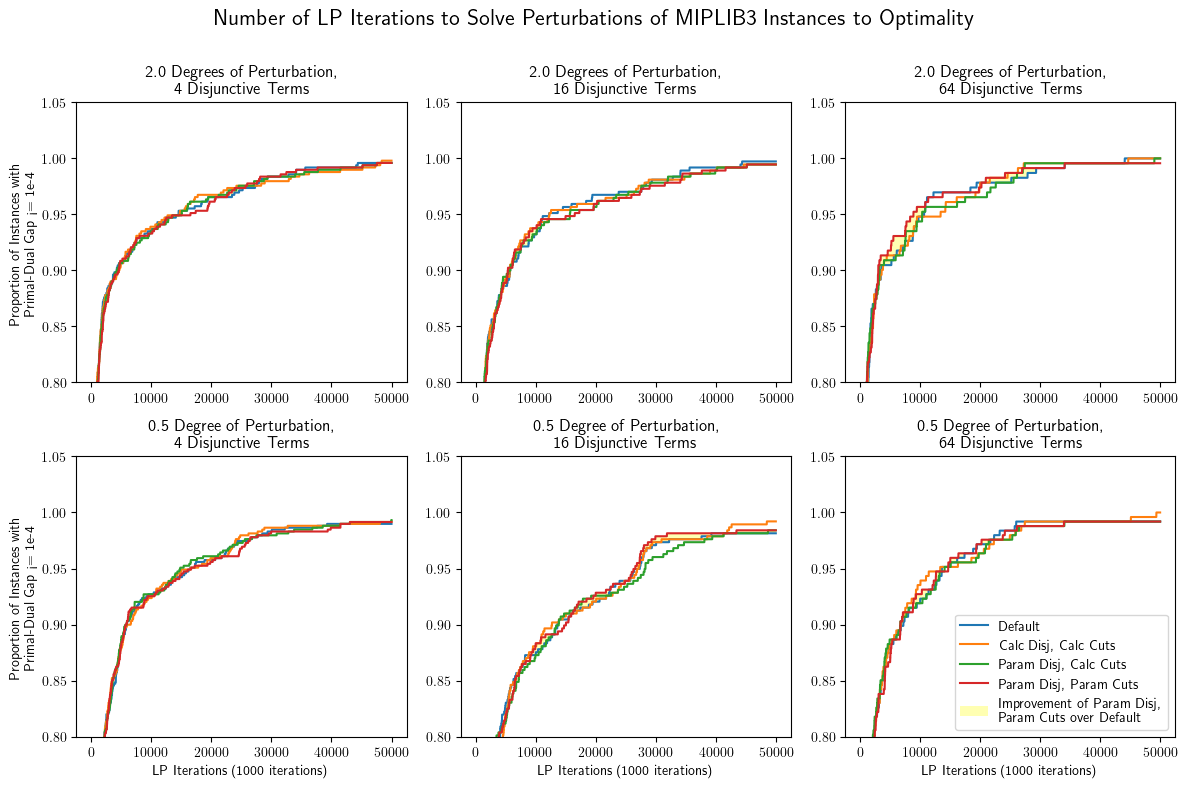

In [91]:
make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [96]:
def make_run_time_boxplot(time_df, perturbation=None, threshold=.1):
    plt.rc('text', usetex=True)  # use latex fonts

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(degrees), len(terms), figsize=(8*len(terms), 4*len(degrees)))
    
    # Iterate through each combination of degree and terms
    for i, degree in enumerate(degrees):
        for j, term in enumerate(terms):
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            axes[i, j].boxplot(instance_data, labels=unique_instances)
            axes[i, j].axhline(cut_off, color='black', linestyle='--', linewidth=1, alpha=.5, label=f"Top {int(threshold * 100)} Percent of Instances")
            axes[i, j].set_ylim(-3, 1)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_title(f"{degree} Degree{'s' if degree >= 2 else ''} "
                                 f"of Perturbation,\n{term} Disjunctive Terms")
            if j == 0:
                axes[i, j].set_ylabel('Relative Time Improvement\n'
                                      '(Param Disj, Param Cuts vs Default)')
            if i == len(degrees) - 1:
                axes[i, j].set_xlabel('Instance')
    
    fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                 f"Param Cuts compared to Default"
                 f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                 f"(positive values imply Param Disj, Param Cuts'"
                 f" run time faster than Default's)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution"
                                       f"{'_' + perturbation if perturbation else ''}.png"),
                dpi=1200)
    plt.legend()
    plt.show()

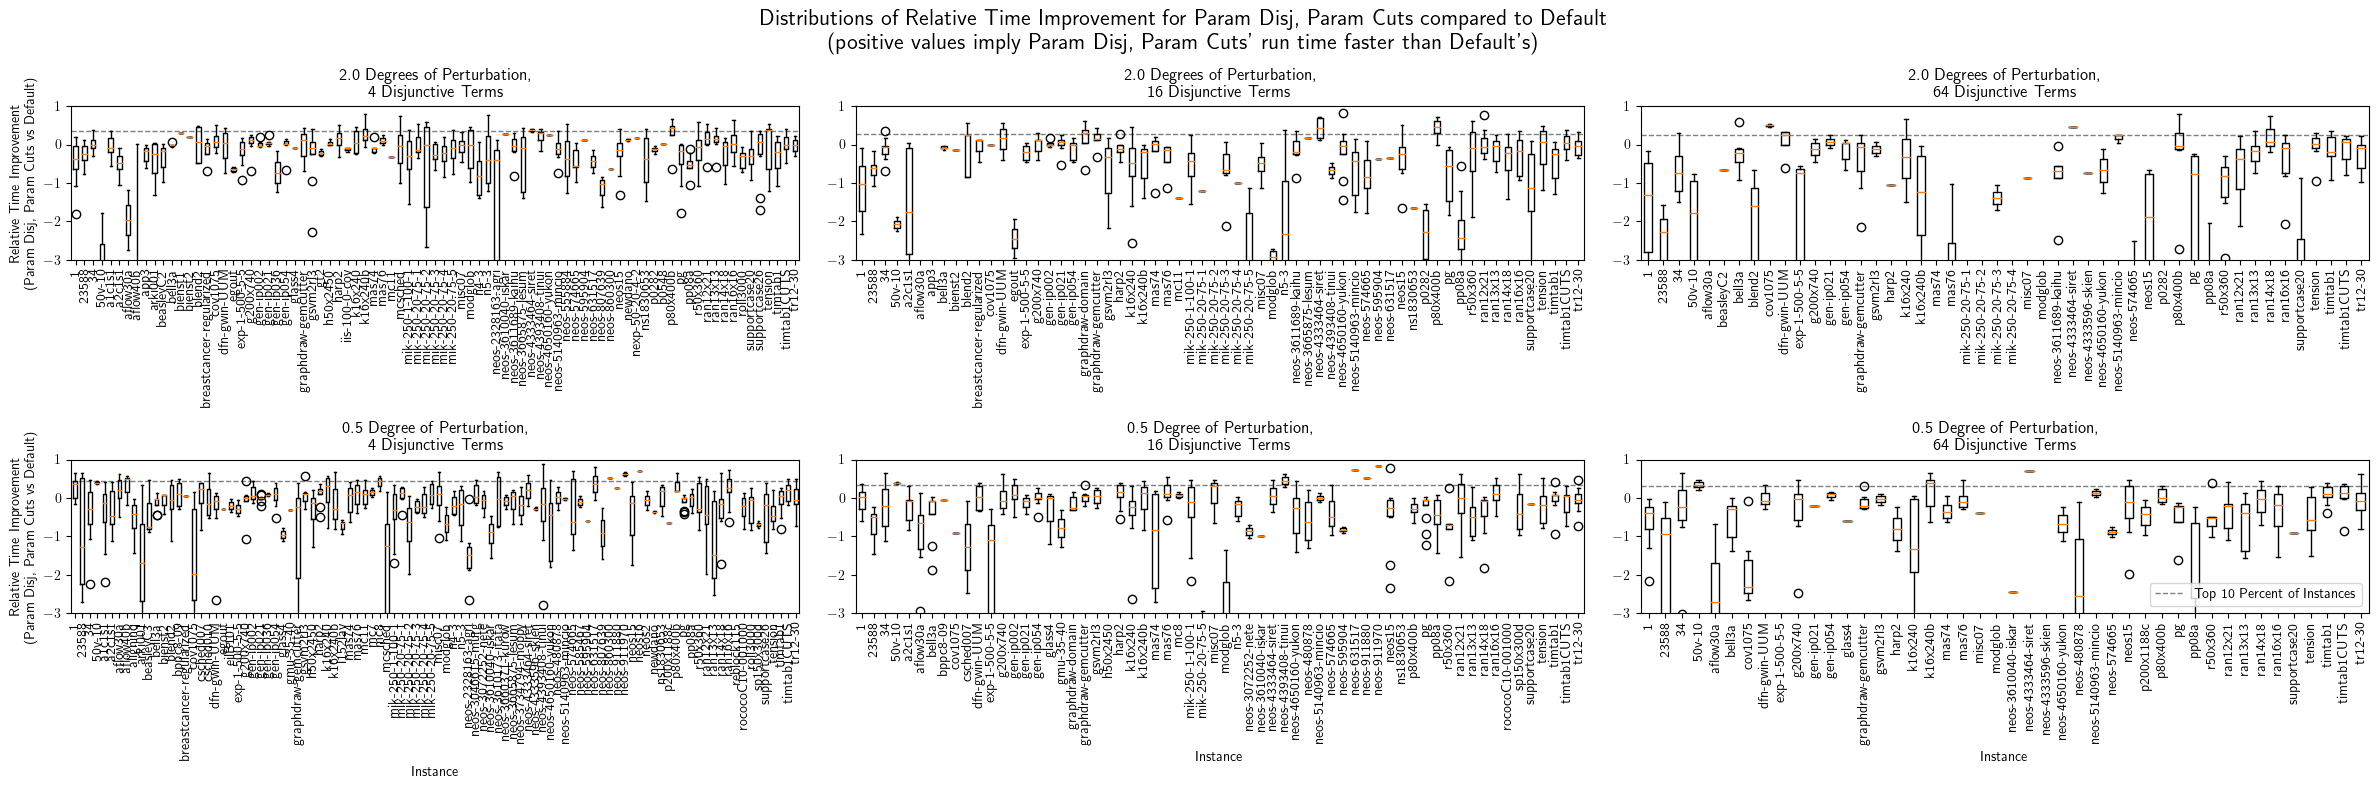

In [97]:
make_run_time_boxplot(time_df)

In [98]:
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


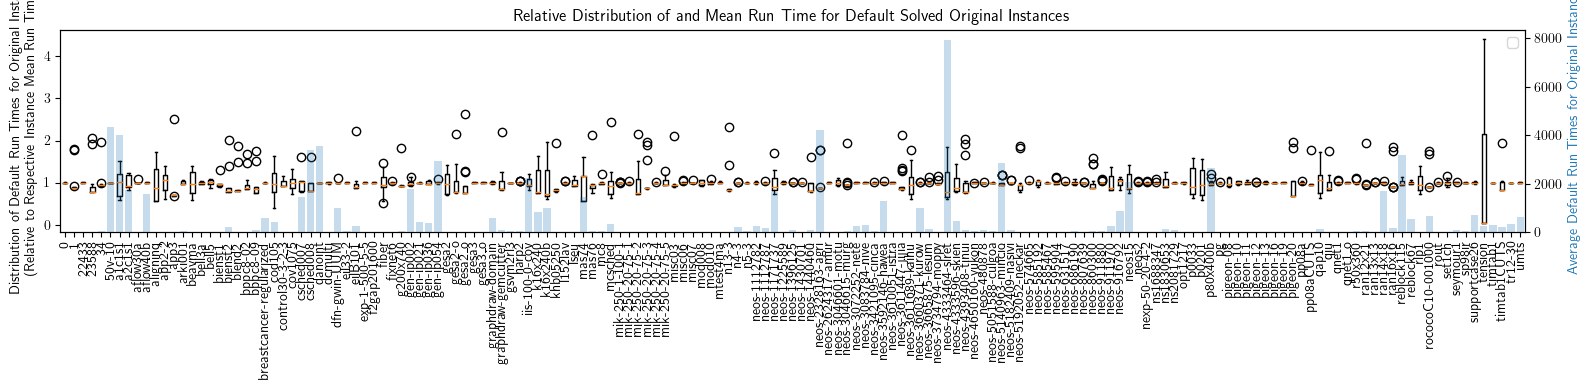

In [99]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times for Original Instances\n'
               '(Relative to Respective Instance Mean Run Time)')
ax1.set_title("Relative Distribution of and Mean Run Time for Default Solved Original Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [100]:
gap_df = df.loc[mask]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [101]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

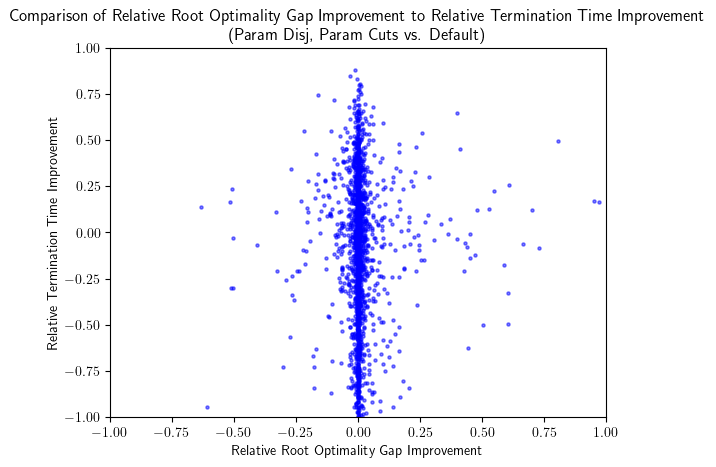

In [102]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Relative Root Optimality Gap Improvement to Relative Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination Time Improvement")
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

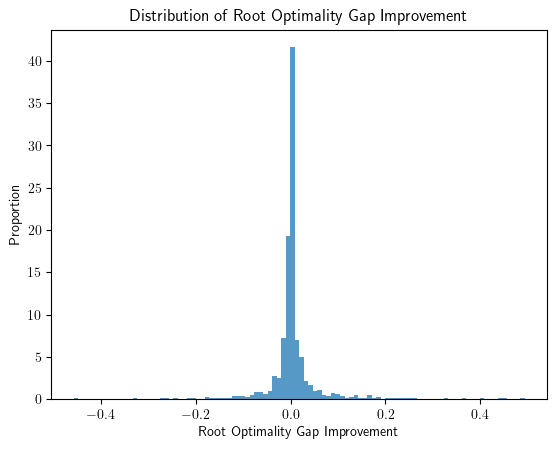

In [103]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

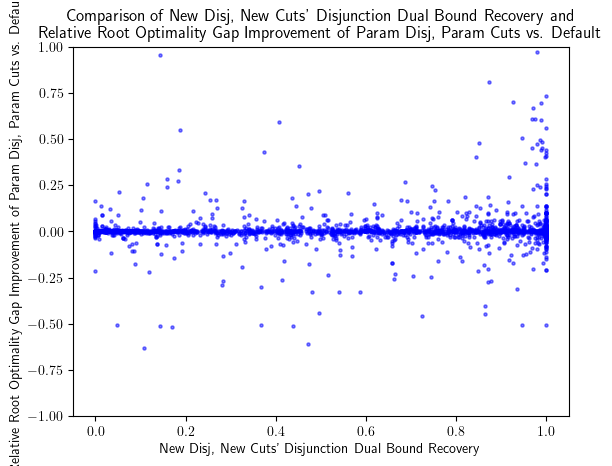

In [104]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.show()

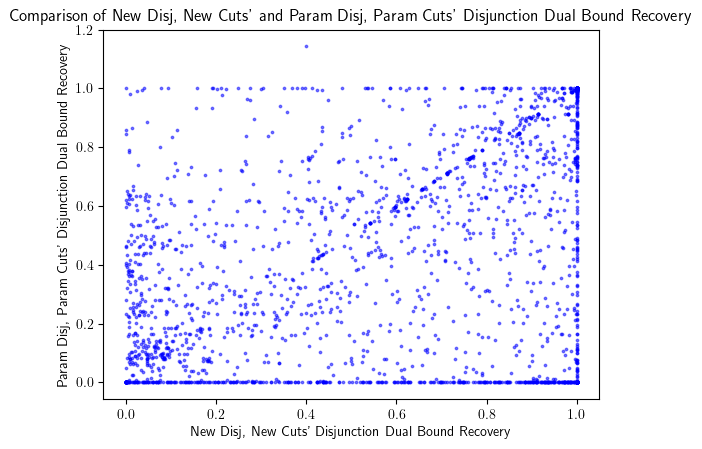

In [105]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [106]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

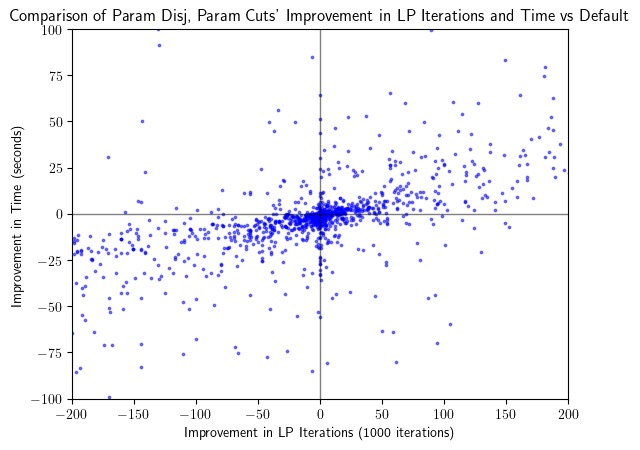

In [107]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

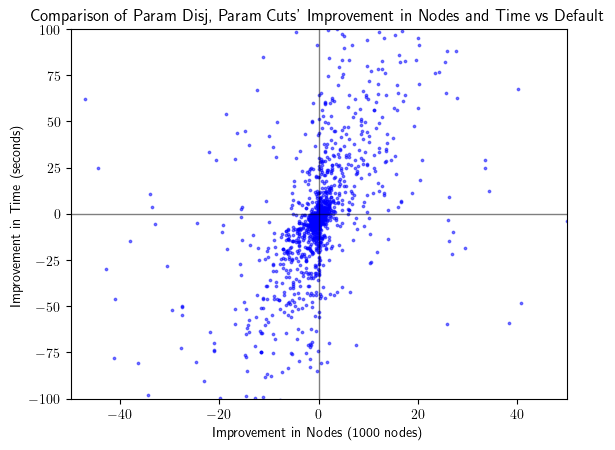

In [108]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

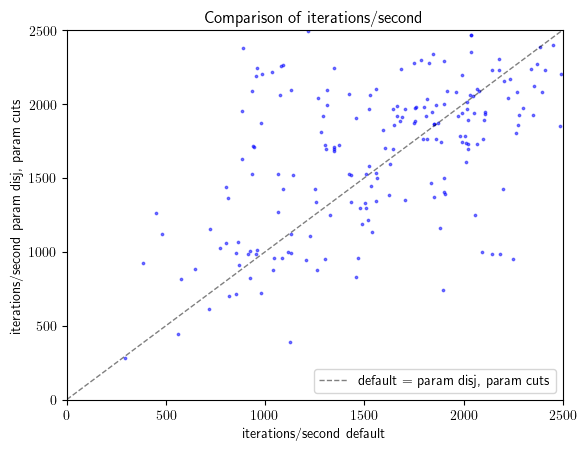

In [109]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

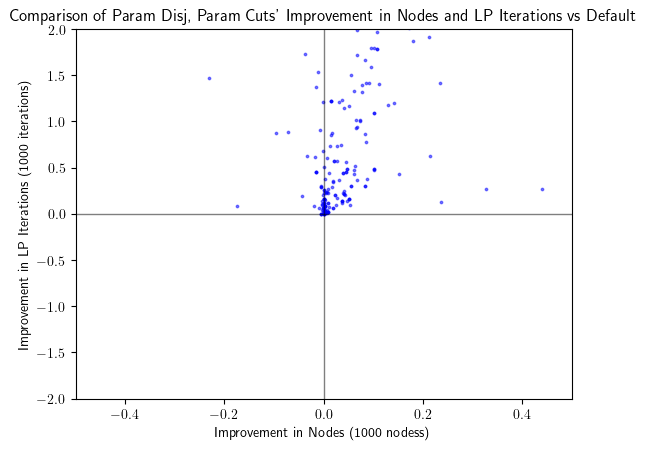

In [110]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

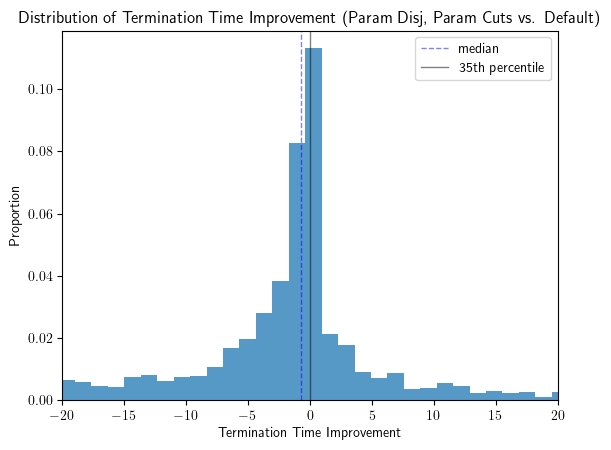

In [113]:
# Create a histogram with 600 bins
plt.hist(gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
         bins=14400, density=True, alpha=0.75)
plt.xlim(-20, 20)

cut_off = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('Termination Time Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Termination Time Improvement (Param Disj, Param Cuts vs. Default)')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

In [114]:
gap_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
4,1,None,4,2577.191573,2577.191573,2577.191573,2627.975967,2665.000000,2665.000000,0.000004,...,2.018160,2.019586,2.059620,19.800764,28.955958,28.852049,28.832683,-0.573718,0.156408,-0.527228
5,3,None,4,2471.641900,2471.641900,2471.641900,2624.556072,2696.000000,2696.000000,0.000004,...,3.813358,4.491156,4.773309,159.574500,149.488803,156.860748,156.848422,-0.013182,0.295190,-0.139385
9,1,None,16,2759.060251,2759.060251,2759.060251,3207.628691,3443.660092,3444.000000,0.000002,...,0.447663,0.519447,0.518852,318.135306,403.412464,412.155350,385.705620,-0.212424,-0.144432,-0.189214
10,3,None,16,2812.990779,2812.990779,2812.990779,3192.136766,3520.649930,3521.000000,0.000002,...,0.391316,0.455186,0.440162,1204.033825,1124.006312,1487.044038,2897.139367,-1.405920,-1.509473,-1.451938
11,4,None,16,2173.225092,2173.225092,2173.225092,2681.781044,2926.809761,2927.000000,0.000002,...,0.317864,0.444052,0.402860,91.766717,53.465220,63.849338,137.597444,-0.498386,-0.507730,-0.601129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,1,None,64,6755.630138,6755.630138,6755.630138,6759.538606,6836.167123,6836.850777,0.000005,...,0.033455,0.033852,0.050779,1877.921164,1621.190782,1368.705646,1826.035573,0.027402,0.000000,0.000000
4584,3,None,64,6770.763110,6770.763110,6770.763110,6775.817754,6848.811413,6849.496227,0.000004,...,0.067884,0.041657,0.041640,756.418815,998.437574,669.549315,667.636957,0.116746,0.139060,0.113372
4588,1,None,16,0.011902,0.011902,0.011902,0.052557,0.294879,0.294879,0.000003,...,0.193025,0.194105,0.194426,31.961095,49.041344,12.442720,41.835455,-0.329778,-0.425701,-0.412420
4589,2,None,16,0.010945,0.010945,0.010945,0.050152,0.283275,0.283275,0.000002,...,0.197270,0.230694,0.138256,33.785165,29.597598,26.519177,27.461417,0.164389,-0.370218,-0.045277


In [121]:
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None", "rootDualBound New"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp["my ratio"] = comp["rootDualBound New"] / comp["rootDualBound None"]
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,my ratio
0,1,4,6637.188027,6641.585617,6640.550919,6714.074468,6716.532958,1.000366
1,1,16,6637.188027,6644.289771,6642.855642,6714.074468,6716.497950,1.000361
2,1,64,6637.188027,6647.648085,6641.628977,6714.074468,6708.438499,0.999161
3,23588,4,7649.866134,7799.912563,7774.120220,7770.367871,7797.326487,1.003469
4,23588,16,7649.866134,7867.860624,7862.267452,7770.367871,7867.450026,1.012494
...,...,...,...,...,...,...,...,...
198,timtab1CUTS,16,618783.684884,624954.797154,620366.145397,632895.730479,633658.012677,1.001204
199,timtab1CUTS,64,618783.684884,632296.230889,630413.602939,632895.730479,633482.153061,1.000927
200,tr12-30,4,25302.209524,25611.359565,25498.481331,129146.721533,129090.840776,0.999567
201,tr12-30,16,25302.209524,26546.641734,25805.491566,129146.721533,129090.840776,0.999567


In [116]:
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS"]]
adf.columns = groups + fields
adf["aleks ratio"] = adf["rootDualBound New"] / adf["rootDualBound None"]
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,aleks ratio
0,22433,2.0,2.124053e+04,21314.98074,2.131206e+04,2.141369e+04,2.140756e+04,0.999713
1,23588,2.0,7.649866e+03,7746.197749,7.726713e+03,7.757177e+03,7.789200e+03,1.004128
2,10teams,2.0,9.170000e+02,917,9.170000e+02,9.240000e+02,9.240000e+02,1.000000
3,30n20b8,2.0,1.241230e+02,124.2095421,1.241823e+02,1.542021e+02,1.528972e+02,0.991538
4,50v-10,2.0,2.879066e+03,2884.065687,2.884066e+03,3.195241e+03,3.199688e+03,1.001392
...,...,...,...,...,...,...,...,...
2637,vpm1,64.0,1.643333e+01,16.71111111,1.660000e+01,1.886429e+01,1.900595e+01,1.007510
2638,vpm2,64.0,1.113563e+01,11.5093094,1.134045e+01,1.305095e+01,1.305186e+01,1.000070
2639,wachplan,64.0,-9.000000e+00,-9,NaN,0.000000e+00,0.000000e+00,NaN
2640,zib54-UUE,64.0,4.330388e+06,5389605.005,4.850439e+06,8.432754e+06,8.397464e+06,0.995815


In [117]:
# join comp and adf on instance and terms
diff = comp[groups + ["my ratio"]].merge(adf[groups + ["aleks ratio"]], on=groups)
diff[np.abs(diff["my ratio"] - diff["aleks ratio"]) > .02]

,instance,terms,my ratio,aleks ratio
21,bienst2,4,1.169338,1.006596
22,bienst2,16,1.086287,1.195931
28,breastcancer-regularized,4,1.280701,1.042262
29,breastcancer-regularized,16,1.279734,0.925203
31,cov1075,16,1.000000,1.034961
60,gsvm2rl3,4,1.509963,1.065242
62,gsvm2rl3,64,1.267143,1.099603
91,misc07,64,1.036042,1.003950
113,neos-4333464-siret,16,1.040162,0.982945
114,neos-4333464-siret,64,1.020563,0.988091


In [118]:
diff[diff.columns[1:]].groupby("terms").mean()

,my ratio,aleks ratio
terms,,
4,1.011423,1.002317
16,1.007624,1.004213
64,1.008820,1.003497


In [119]:
adf[["terms", "aleks ratio"]].groupby("terms").mean()

,aleks ratio
terms,
2.0,1.227926
4.0,1.218641
8.0,1.231829
16.0,1.240385
32.0,1.263117
64.0,1.034405
